In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install transformers trl accelerate torch bitsandbytes peft datasets -qU

In [ ]:
!pip install evaluate

#### Load HF Dataset

First things first, we need to load our `mosaicml/instruct-v3` dataset. It's a great collection of effective and safe tasks.

In [ ]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("gsm8k", "main")

Let's take a peek at our dataset.

It's our job to merge these `prompt` and `response` columns into a single formatted prompt for instruct-tuning.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

Since we want to generate a model that generates instructions - we're going to filter away all the subset datasets and only used the `dolly_hhrlhf` component!

In [ ]:
# dataset = dataset.filter(lambda x: x["source"] == "dolly_hhrlhf")

In [ ]:
ds_train_devtest = dataset['train'].train_test_split(test_size=0.2, seed=42)
ds_train_devtest

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 5978
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1495
    })
})

We're going to train on a small subset of the data - if you were considering an Epoch based approach this would reduce the amount of time spent training!

In [ ]:
ds_splits = DatasetDict({
    'train': ds_train_devtest['train'],
    'valid': ds_train_devtest['test'],
    'test': dataset['test']
})
dataset = ds_splits

In [ ]:
# dataset["train"] = dataset["train"].select(range(100))
train = dataset["train"]

In [ ]:
# dataset["valid"] = dataset["valid"].select(range(20))
valid = dataset["valid"]

In [ ]:
# dataset["test"] = dataset["test"].select(range(20))
test = dataset["test"]

In [ ]:
# dataset["train"][:10]

#### Create Formatted Prompt

In the following function we'll be merging our `prompt` and `response` columns by creating the following template:

```
<s>### Instruction:
Use the provided input to create an instruction that could have been used to generate the response with an LLM.

### Input:
{input}

### Response:
{response}</s>
```

In [ ]:
print(dataset["train"][0])

{'question': 'Alicia had a wonderful birthday party where she got lots of presents. 10 of the presents were in small boxes. 12 of the presents were in medium boxes. A third of all the presents she is given are in large boxes. How many presents did Alicia get for her birthday?', 'answer': 'Alicia got 10 small boxed presents + 12 medium boxed presents = <<10+12=22>>22 presents.\nA third of all the presents Alicia gets are in large boxes, 22 / 2 = <<22/2=11>>11 is half of the presents we know Alicia got.\n11 x 3 = <<11*3=33>>33 presents Alicia got on her birthday.\n#### 33'}


In [ ]:
def create_prompt(examples):
  combined_strings = []

  for item in dataset["train"]:
      # Combine 'question' and 'answer' values and add them to the list
      combined_string = f"### Question: {item['question']}\n ### Answer: {item['answer']}"
      combined_strings.append(combined_string)
  return combined_strings



In [ ]:
# def create_prompt(example):
#   output_texts = []
#   i = len(example) // 2
#   for j in range(i):
#       text = f"### Question: {example['question'][j]}\n ### Answer: {example['answer'][j]}"
#       output_texts.append(text)
#   return output_texts





# bos_token = "<s>"
# system_message = "Find the solution to the following math problem."
# question = sample["question"]
# # print(question)
# answer = sample["answer"]
# eos_token = "</s>"

# full_prompt = ""
# full_prompt += bos_token
# # full_prompt += "### Instruction:"
# # full_prompt += "\n" + system_message
# full_prompt += "\n\n### Question:"
# full_prompt += "\n" + question
# full_prompt += "\n\n### Answer:"
# full_prompt += "\n" + answer
# full_prompt += eos_token

# return full_prompt

In [ ]:
create_prompt(dataset["train"])

['### Question: Alicia had a wonderful birthday party where she got lots of presents. 10 of the presents were in small boxes. 12 of the presents were in medium boxes. A third of all the presents she is given are in large boxes. How many presents did Alicia get for her birthday?\n ### Answer: Alicia got 10 small boxed presents + 12 medium boxed presents = <<10+12=22>>22 presents.\nA third of all the presents Alicia gets are in large boxes, 22 / 2 = <<22/2=11>>11 is half of the presents we know Alicia got.\n11 x 3 = <<11*3=33>>33 presents Alicia got on her birthday.\n#### 33',
 "### Question: A jar on the family's counter contains change they've been saving a trip to the ice cream shop. There are 123 pennies, 85 nickels, 35 dimes, and a number of quarters. All five family members get a double scoop, which costs $3 each. After the trip, they have 48 cents left over. How many quarters were in the jar?\n ### Answer: The family spent $15 on ice cream because 5 x 3 = <<5*3=15>>15\nThey total 

### Loading the Base Model

We're going to load our model in `4bit`, with double quantization, with `bfloat16` as our compute dtype.

You'll notice we're loading the instruct-tuned model - this is because it's already adept at following tasks - we're just teaching it a new one!

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",
    device_map='auto',
    quantization_config=nf4_config,
    use_cache=False
)

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T")
# tokenizer.pad_token = tokenizer.unk_token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

Let's example how well the model does at this task currently:

In [ ]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs, max_new_tokens=64, do_sample=True, pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

In [ ]:
generate_response("<s>### Instruction:\nFind the solution to the following math problem.\n\n### Input:\nNatalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\n\n### Response:", model)

'<s><s> ### Instruction:\nFind the solution to the following math problem.\n\n### Input:\nNatalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\n\n### Response:\n\n### Connections:\n\n### Solutions:\n\n##### Python 3 Code:\n\n##### Rust Code:\n{% highlight rust %}\nlet total = 48 + 48 / 2 + 48 / 2 * 0.5;'

Now, we're going to prepare our model for 4bit LoRA training!

We can use these handy helper functions to achieve this goal thanks to `huggingface` and the `peft` library!

In [ ]:
from peft import AutoPeftModelForCausalLM, LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

In [ ]:
import evaluate
import re
# def compute_metrics(example):
#     return _compute_metrics(example, tokenizer)

# def _compute_metrics(example, tokenizer):
#     """
#     Overridden method
#     """
#     metric = evaluate.load("accuracy")
#     logits, labels = example
#     print("labels: ", labels)
#     labels = tokenizer.batch_decode(torch.tensor(labels))
#     output = torch.argmax(torch.tensor(logits), dim=-1)
#     predictions = tokenizer.batch_decode(torch.tensor(output))
#     print("logits: ", logits)
#     print("predictions: ", predictions)
#     print("labels: ", labels)
#     labels = labels.split("#### ")[-1]
#     pattern = r"[-+]?\d*\.\d+|\d+/\d+|\d+"
#     matches = re.findall(pattern, predictions)
#     predictions = matches[-1]
#     return metric.compute(predictions=predictions, references=labels)

All that's left to do is set up a number of hyper parameters.

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
  output_dir = "training_results",
  num_train_epochs = 1,
  # max_steps = 100, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 4,
  warmup_steps = 0.03,
  logging_steps=300,
  save_strategy="epoch",
  # evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=300, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=1e-3,
  fp16=True,
  lr_scheduler_type='constant',
  logging_dir="./logs",
)

In [ ]:
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
instruction_template = "### Question:"
response_template = "### Answer:"

response_template_ids = tokenizer.encode(response_template, add_special_tokens=False)[2:]  # Now we have it like in the dataset texts: `[2277, 29937, 4007, 22137, 29901]`
instruction_template_ids = tokenizer.encode(instruction_template, add_special_tokens=False)[2:]  # Now we have it like in the dataset texts: `[2277, 29937, 4007, 22137, 29901]`

collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template_ids, response_template=response_template_ids, tokenizer=tokenizer, mlm=False)


In [ ]:
from trl import SFTTrainer

max_seq_length = 128

# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T")
# tokenizer.pad_token = tokenizer.unk_token

# tokenizer.padding_side = "right"

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=False,
  formatting_func=create_prompt,
  args=args,
  train_dataset=train,
  eval_dataset=valid,
  # compute_metrics=compute_metrics,
  data_collator=collator

)

Map:   0%|          | 0/5978 [00:00<?, ? examples/s]

Map:   0%|          | 0/1495 [00:00<?, ? examples/s]

In [ ]:
# metrics_initial = trainer.evaluate(eval_dataset=dataset["train"])
# print(f"baseline metrics???: {metrics_initial}")

In [ ]:
trainer.train()
trainer.save_model()


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
300,1.378700,1.305394
600,1.302800,1.261718
900,1.248500,1.238591
1200,1.221500,1.203573
1500,1.200200,1.182276
1800,1.196000,1.156531
2100,1.168500,1.133745
2400,1.152200,1.118603
2700,1.131900,1.099331
3000,1.101800,1.076046


Buffered data was truncated after reaching the output size limit.

In [ ]:
# print(dataset["test"])
# train_metrics = trainer.evaluate(eval_dataset=train)
# print(f"train metrics (finetuned): {train_metrics}")
# test_metrics = trainer.evaluate(eval_dataset=dataset["test"])
# print(f"test metrics: {test_metrics}")

In [ ]:
eval = trainer.evaluate()

In [ ]:
print(eval)

{'eval_loss': 0.7841761708259583, 'eval_runtime': 402.0683, 'eval_samples_per_second': 29.736, 'eval_steps_per_second': 3.718, 'epoch': 1.0}


In [ ]:
# trainer.save_model("mistral_instruct_generation")

# Save Model and Push to Hub

4bit save and push coming soon!

The PR is literally in the process of being added! Check it out [here](https://github.com/TimDettmers/bitsandbytes/pull/753)!

For now, we'll save our adapters!

In [ ]:
def generate_response(prompt, model):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs, max_new_tokens=64, do_sample=False, pad_token_id=tokenizer.unk_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0]

In [ ]:
generate_response("<s>### Instruction:\nFind the solution to the following math problem.\n\n### Input:\nNatalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\n\n### Response:", model)

'<s><s> ### Instruction:\nFind the solution to the following math problem.\n\n### Input:\nNatalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?\n\n### Response: Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips in April and May.\n#### 72 clips in'

In [ ]:
generate_response("The moon is made of 50% iron, 20% carbon, and the remainder is other elements. Mars weighs twice as much as the moon, but has the exact same composition. If Mars is 150 tons of other elements, how many tons does the moon weigh?", model)

'<s> The moon is made of 50% iron, 20% carbon, and the remainder is other elements. Mars weighs twice as much as the moon, but has the exact same composition. If Mars is 150 tons of other elements, how many tons does the moon weigh?\n ### Answer\nIf Mars weighs twice as much as the moon, then the moon weighs 150/2=<<150/2=75>>75 tons.\nIf Mars has the exact same composition, then the moon weighs 75/50'

In [ ]:
generate_response("Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?'", model)

"<s> Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?'\n ### 50 minutes is equivalent to $0.50/minute so she earned 50 * 0.50/minute = $<<50*0.50/minute=25.00>>25.00\n#### 25.0"

In [ ]:
trainer.state.log_history

[{'loss': 1.3787,
  'grad_norm': 0.42918699979782104,
  'learning_rate': 0.001,
  'epoch': 0.03,
  'step': 300},
 {'eval_loss': 1.3053936958312988,
  'eval_runtime': 401.8817,
  'eval_samples_per_second': 29.75,
  'eval_steps_per_second': 3.72,
  'epoch': 0.03,
  'step': 300},
 {'loss': 1.3028,
  'grad_norm': 0.38896501064300537,
  'learning_rate': 0.001,
  'epoch': 0.07,
  'step': 600},
 {'eval_loss': 1.2617180347442627,
  'eval_runtime': 402.3842,
  'eval_samples_per_second': 29.713,
  'eval_steps_per_second': 3.715,
  'epoch': 0.07,
  'step': 600},
 {'loss': 1.2485,
  'grad_norm': 0.43494653701782227,
  'learning_rate': 0.001,
  'epoch': 0.1,
  'step': 900},
 {'eval_loss': 1.2385907173156738,
  'eval_runtime': 402.3572,
  'eval_samples_per_second': 29.715,
  'eval_steps_per_second': 3.716,
  'epoch': 0.1,
  'step': 900},
 {'loss': 1.2215,
  'grad_norm': 0.45639654994010925,
  'learning_rate': 0.001,
  'epoch': 0.13,
  'step': 1200},
 {'eval_loss': 1.2035728693008423,
  'eval_runtime

In [ ]:
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)
df


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.3787,0.429187,0.001,0.03,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.03,300,1.305394,401.8817,29.750,3.720,NaN,NaN,NaN,NaN,NaN
2,1.3028,0.388965,0.001,0.07,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.07,600,1.261718,402.3842,29.713,3.715,NaN,NaN,NaN,NaN,NaN
4,1.2485,0.434947,0.001,0.10,900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.10,900,1.238591,402.3572,29.715,3.716,NaN,NaN,NaN,NaN,NaN
6,1.2215,0.456397,0.001,0.13,1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.13,1200,1.203573,402.0111,29.740,3.719,NaN,NaN,NaN,NaN,NaN
8,1.2002,0.538115,0.001,0.17,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.17,1500,1.182276,402.1256,29.732,3.718,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_loss = df.dropna(subset=['loss'])
train_list = train_loss["loss"].values.tolist()
train_list

[1.3787,
 1.3028,
 1.2485,
 1.2215,
 1.2002,
 1.196,
 1.1685,
 1.1522,
 1.1319,
 1.1018,
 1.1085,
 1.0937,
 1.0794,
 1.0633,
 1.0516,
 1.045,
 1.0336,
 1.0152,
 1.0114,
 0.9909,
 0.9853,
 0.9816,
 0.9335,
 0.9472,
 0.9324,
 0.9215,
 0.9064,
 0.8984,
 0.883]

In [ ]:
eval_loss = df.dropna(subset=['eval_loss'])
# eval_loss["eval_loss"]
eval_list = eval_loss["eval_loss"].values.tolist()
eval_list

[1.3053936958312988,
 1.2617180347442627,
 1.2385907173156738,
 1.2035728693008423,
 1.1822761297225952,
 1.1565306186676025,
 1.1337453126907349,
 1.118602991104126,
 1.0993309020996094,
 1.076046109199524,
 1.063984990119934,
 1.045544981956482,
 1.0312799215316772,
 1.0090574026107788,
 0.9906860589981079,
 0.973129153251648,
 0.9664910435676575,
 0.9532866477966309,
 0.9299406409263611,
 0.912092387676239,
 0.8967108726501465,
 0.8836878538131714,
 0.8737420439720154,
 0.8588383793830872,
 0.8461334109306335,
 0.8296192288398743,
 0.8179906606674194,
 0.8076707124710083,
 0.7953177690505981,
 0.7841761708259583]

[0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600, 3900, 4200, 4500, 4800, 5100, 5400, 5700, 6000, 6300, 6600, 6900, 7200, 7500, 7800, 8100, 8400]
29
29


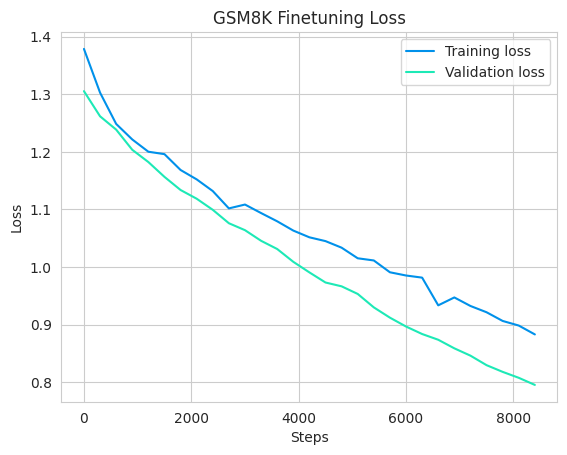

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style("")
# Example lists containing training and validation loss values
palette = ["#0091ea", "#1de9b6"]
sns.set_palette(palette)
nums = [300 * i for i in range(len(train_list))]
print(nums)
# Define x-axis (epochs)
# steps = range(1, len(train_list))
print(len(train_list))
print(len(eval_list))
eval_list = eval_list[:29]
# Plotting
plt.plot(nums, train_list, label='Training loss')
plt.plot(nums, eval_list, label='Validation loss')
plt.title('GSM8K Finetuning Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Show plot
# plt.show()
plt.savefig("gsm8k.svg")